# 2022-08-17 • Investigate correlated spikers

Cors between inputs and unconnected:
- split between inh and exc inputs
- why those few ouliers with high cor?

Also basic test: only 40 unconnected tested, so only 2 needed for FPR of 5%. So test with more to exclude low-N effect.

## Imports

In [1]:
#

In [3]:
using Revise

In [4]:
using MyToolbox

In [5]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Params

Based on Roxin; same as previous nb's.

In [6]:
d = 6
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1, 801],
);

## Run sim

In [7]:
s = cached(sim, [p.sim]);

In [8]:
s = augment_simdata(s, p);

## Sanity check for high FPR: test more unconnected

In [9]:
p2 = @set p.evaluation.N_tested_presyn = 200;

200 instead of 40, that's 5x.
And it's 1/5th of all 1000 neurons.

In [10]:
m = 1;

In [11]:
v = s.signals[m].v
ii = get_input_info(m, s, p2);
ii.num_inputs

(exc = 26, inh = 10)

In [12]:
perf2 = cached(evaluate_conntest_perf, [v, ii.spiketrains, p2], key = [p2, m]);

Testing connections: 100%|██████████████████████████████| Time: 0:03:16m
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\evaluate_conntest_perf\89b55eb8ef8d2542.jld2` … done (14.0 s)


In [14]:
perf2.detection_rates

(TPR_exc = 0.154, TPR_inh = 1, FPR = 0.13)

In [18]:
count(perf2.p_values.unconn .< 0.05)

26

In [19]:
26/200

0.13

In [20]:
10/200

0.05

So yes, we still have the higher-than-α FPR. It's not a small N effect: FP = 26 vs the expected 10 of α = 5%.

## Bin & cor spiketrains again

Re-run conntests but only for 40 tested (too much cors otherwise).

In [21]:
perf = cached(evaluate_conntest_perf, [v, ii.spiketrains, p], key = [p, m]);

In [22]:
v = s.signals[m].v
ii = get_input_info(m, s, p);
ii.num_inputs

(exc = 26, inh = 10)

Split unconnected by their connection test significance:

In [24]:
signif_unconn = ii.unconnected_neurons[findall(perf.p_values.unconn .< p.evaluation.α)];
tested_unconn = ii.unconnected_neurons[1:p.evaluation.N_tested_presyn]
insignif_unconn = [n for n in tested_unconn if n ∉ signif_unconn];

In [25]:
length(signif_unconn), length(tested_unconn)

(6, 40)

Now bin spiketrains..

In [250]:
binned_spikes = [bin(s.spike_times[n], duration = 10minutes, binsize = 100ms) for n in s.neuron_IDs];

..and correlate unconnected with connected.

We have four combo's: {FP, TN} x {exc inputs, inh inputs}

In [37]:
spikecors(group_A, group_B) = vec([cor(binned_spikes[m], binned_spikes[n]) for m in group_A, n in group_B]);

### Plot

In [33]:
using PyPlot

In [34]:
using VoltoMapSim.Plot

In [35]:
jn(strs...) = join(strs, "\n");

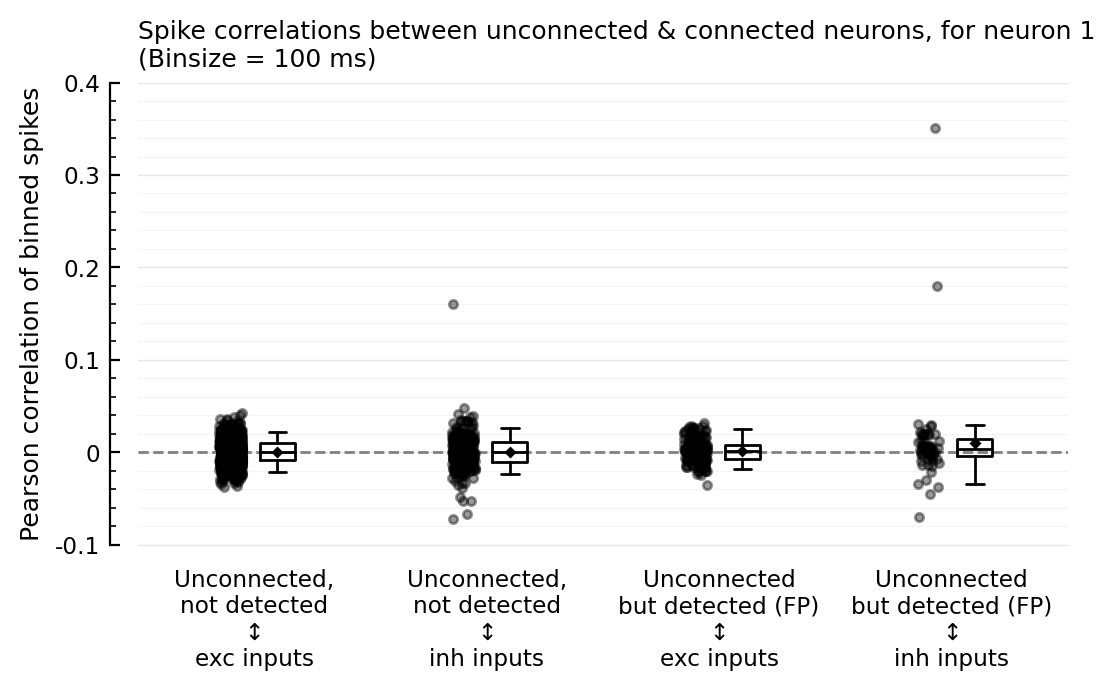

In [266]:
function corplot(; binsize)
    binned_spikes = [bin(s.spike_times[n], duration = 10minutes; binsize) for n in s.neuron_IDs];
    spikecors(group_A, group_B) = vec([cor(binned_spikes[m], binned_spikes[n]) for m in group_A, n in group_B]);
    ax = ydistplot(
        jn("Unconnected,", "not detected", "↕", "exc inputs") => spikecors(insignif_unconn, ii.exc_inputs),
        jn("Unconnected,", "not detected", "↕", "inh inputs") => spikecors(insignif_unconn, ii.inh_inputs),
        jn("Unconnected", "but detected (FP)", "↕", "exc inputs") => spikecors(signif_unconn, ii.exc_inputs),
        jn("Unconnected", "but detected (FP)", "↕", "inh inputs") => spikecors(signif_unconn, ii.inh_inputs),
        figsize = (6, 3),
        hylabel = jn("Spike correlations between unconnected & connected neurons, for neuron $m",
                     "(Binsize = $(binsize/ms) ms)"),
        ylabel = "Pearson correlation of binned spikes",
    )
    add_refline(ax, 0, zorder=1, c="gray")
    return ax
end
ax = corplot(binsize=100ms);

So the strong-correlation outliers are with inhibitory inputs.

And the (slightly) higher correlation seems to be for inh inputs, not exc.

But we must zoom in a bit:

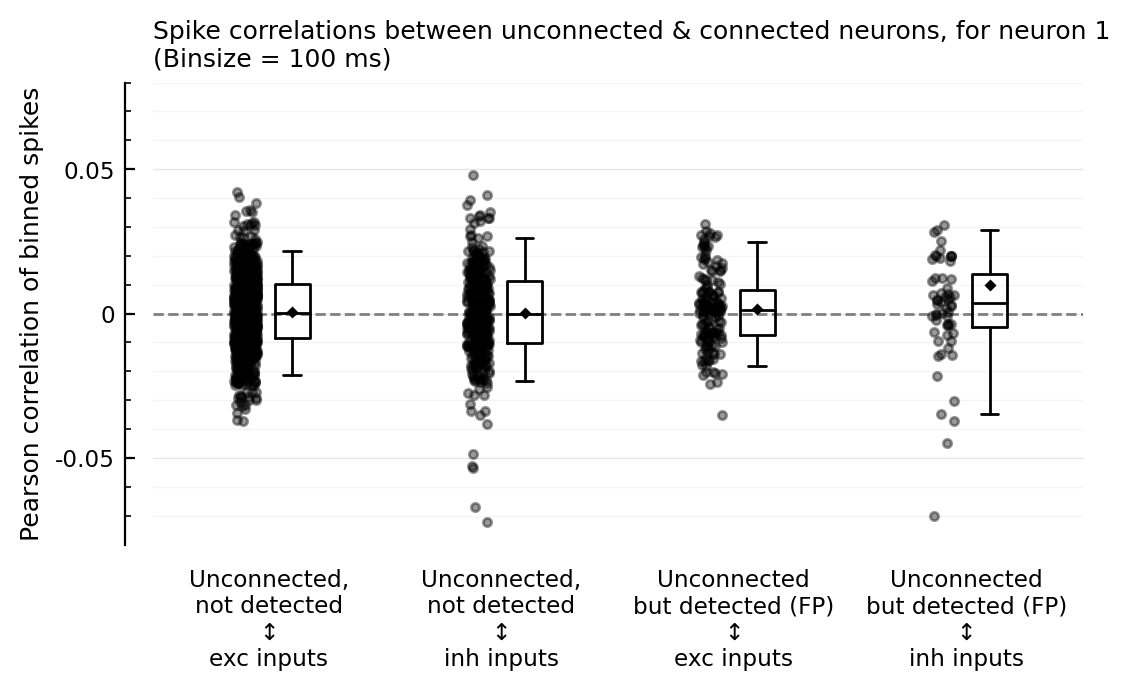

In [258]:
set(ax, ylim=(-0.08, 0.08), xtype=:keep)
ax.figure

We expected the FP correlations with exc to be higher.
But it's higher with inh.
That makes sense though as the inh→exc connections were better detected than the exc→exc. (neuron `1` is exc).

### Other binsizes

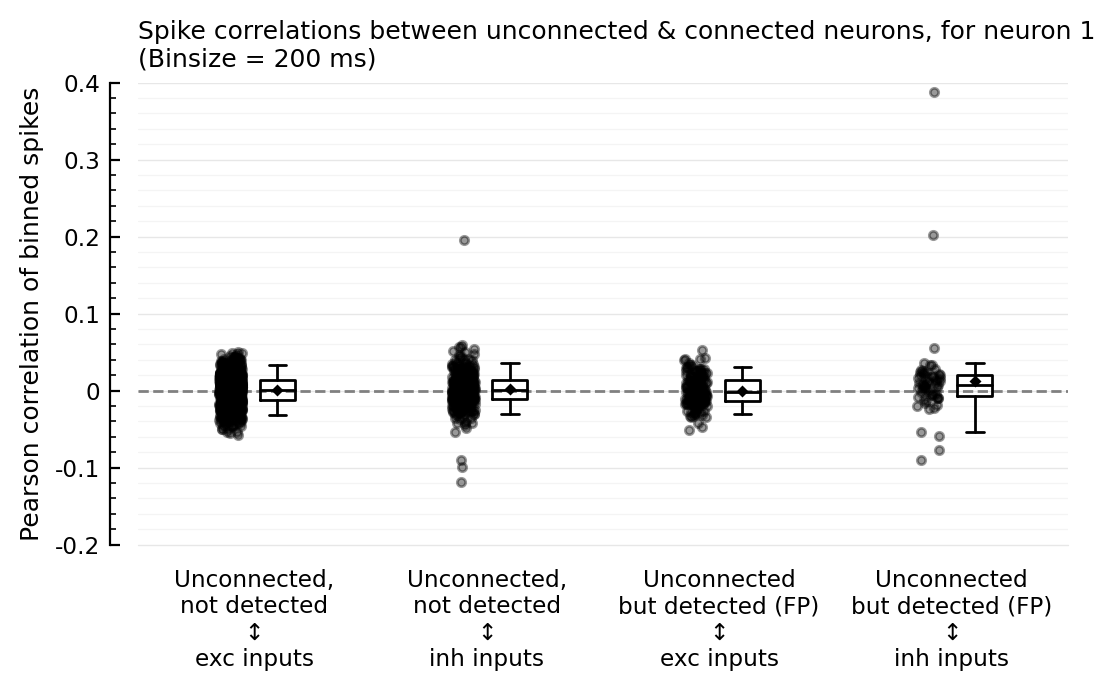

In [271]:
corplot(binsize=200ms);

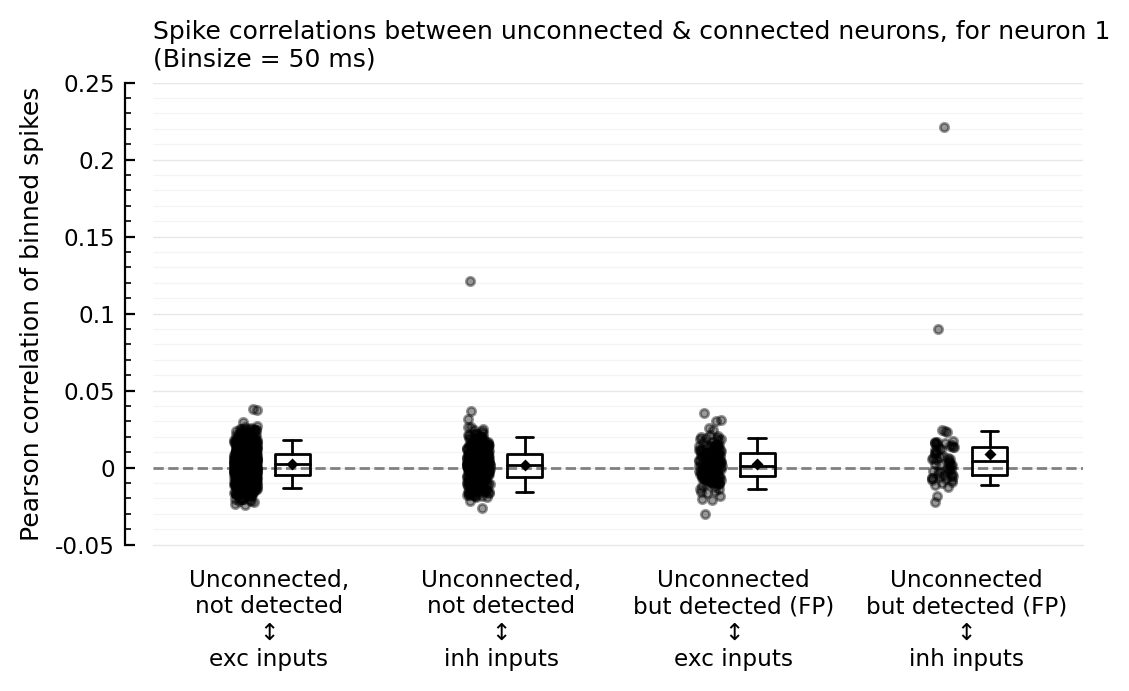

In [268]:
corplot(binsize=50ms);

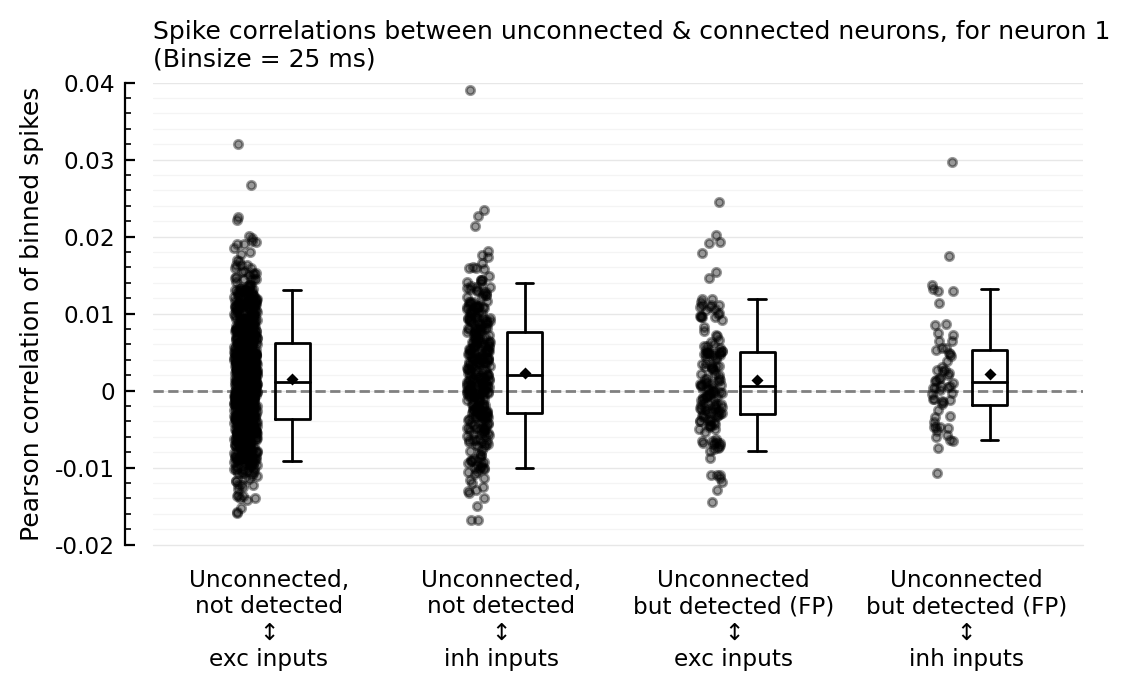

In [270]:
corplot(binsize=25ms);

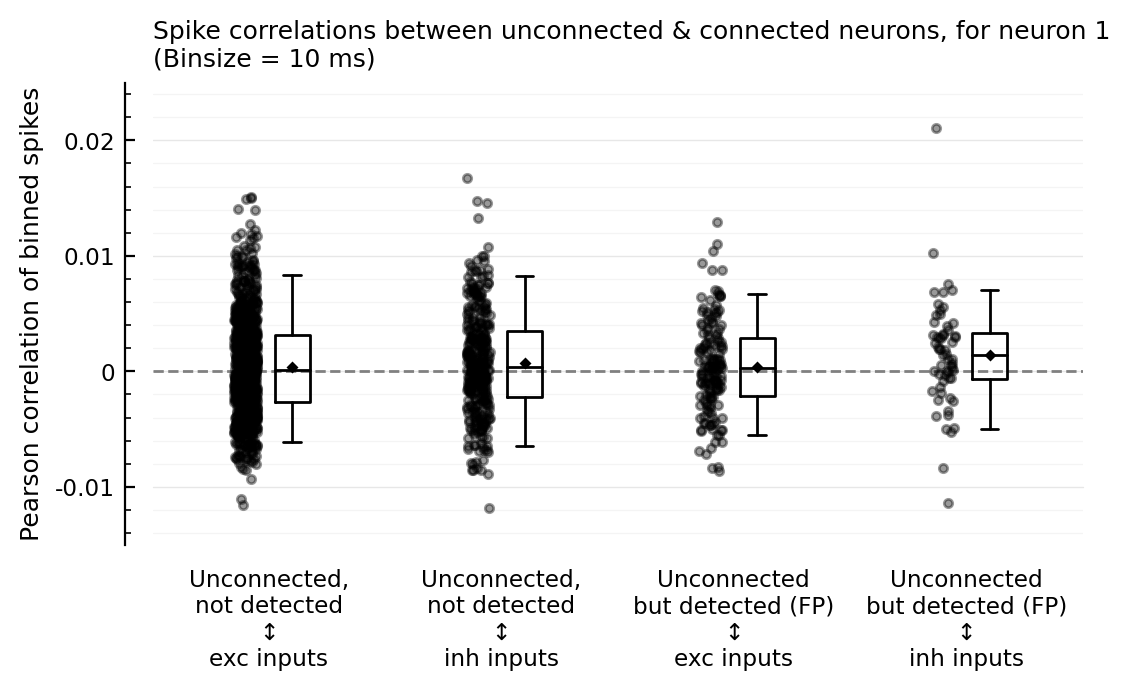

In [273]:
corplot(binsize=10ms);

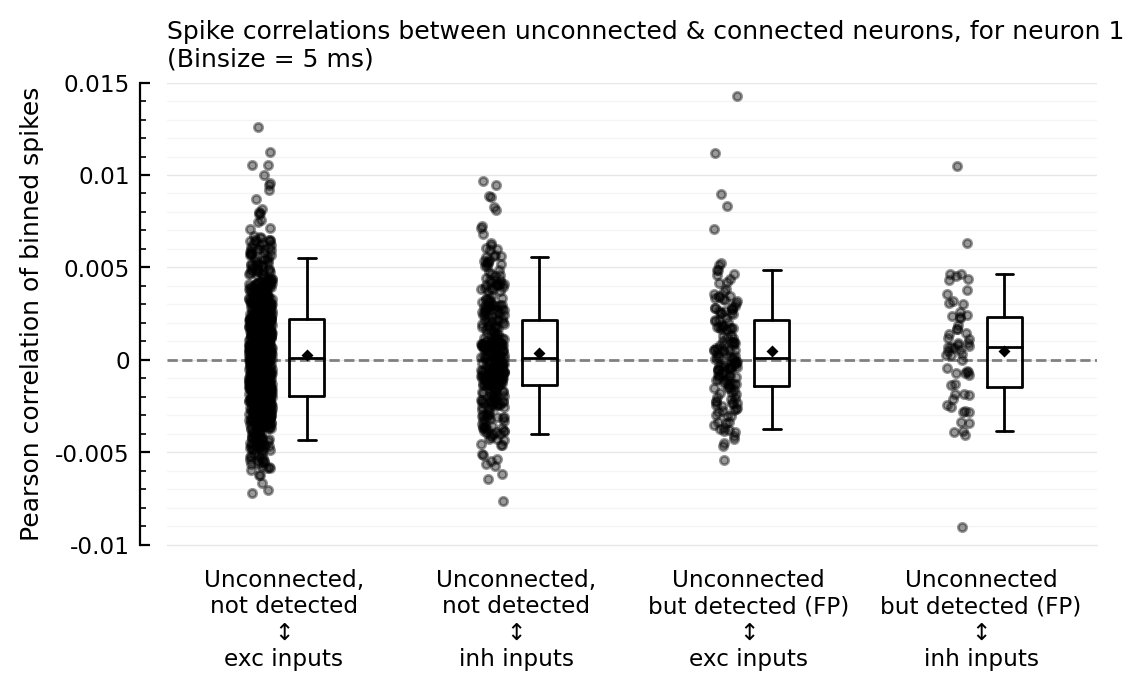

In [275]:
corplot(binsize=5ms);

So the outliers remain for binsizes 50 and 200, and the FP ↔ inh nonzero corr seems to too.
For binsize 25 ms however, both phenomena disappear; but then for 10 and 5 ms, the nonzero corr seems to be back.

## All spike correlations in network

We need to sample, as calculating 1000x1000 spiketrain correlations takes too long.

In [279]:
ns = sample(s.neuron_IDs, 100, replace=false);

In [308]:
spikecors_nosame(A,B) = vec([cor(binned_spikes[m], binned_spikes[n]) for m in A, n in B if m != n]);

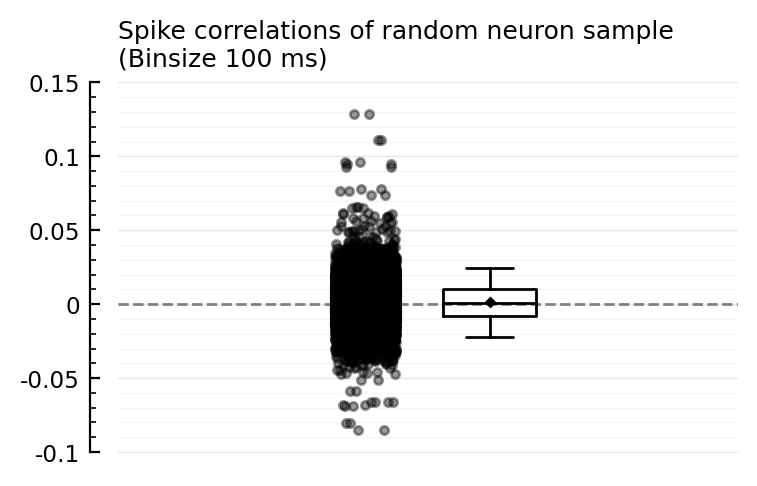

In [309]:
ydistplot(""=>spikecors_nosame(ns,ns), ref=0, hylabel=jn("Spike correlations of random neuron sample", "(Binsize 100 ms)"));

So the 0.15 to 0.35 outliers we saw are in fact rare.

Split by neuron types

In [310]:
ns_exc = [m for m in ns if m in s.neuron_IDs.exc]
ns_inh = [m for m in ns if m in s.neuron_IDs.inh];

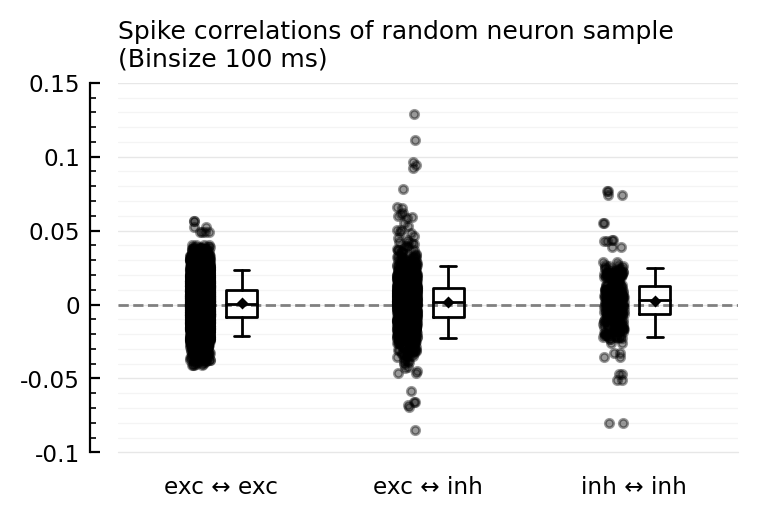

In [312]:
ydistplot(
    "exc ↔ exc" => spikecors_nosame(ns_exc, ns_exc),
    "exc ↔ inh" => spikecors_nosame(ns_exc, ns_inh),
    "inh ↔ inh" => spikecors_nosame(ns_inh, ns_inh),
    ref=0,
    hylabel=jn("Spike correlations of random neuron sample", "(Binsize 100 ms)")
);

inhibitory neurons seem on average to be more correlated with other neurons than excitatory neurons are.

## Investigate outliers

What do their STA's and spiketrains look like?  
How are they connected in network?  
Why does that one have high cor but is still undetected?